   year  record_count   change  cumulative
0  2015        664945   664945      664945
1  2016       1217925  1217925     1882870
2  2017       1925223  1925223     3808093
3  2018       2825985  2825985     6634078
4  2019       3959252  3959252    10593330
5  2020       5449278  5449278    16042608
6  2021       6126926  6126926    22169534
7  2022       6687786  6687786    28857320


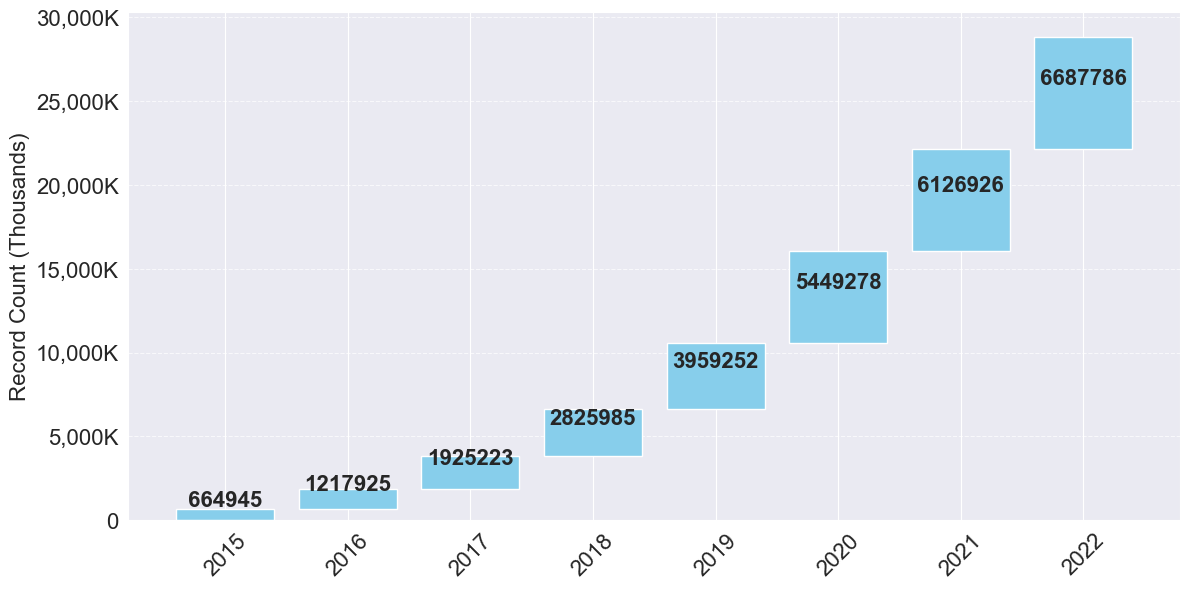

In [3]:
from clickhouse_driver import Client
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Establish a connection with the ClickHouse server
ch_client = Client(
    host='',
    port=3306,
    user='',
    password='',
    database=''
)
sql_query = """
SELECT
    toYear(time) AS year,
    count() AS record_count
FROM
    npm_records_v1
GROUP BY
    year
ORDER BY
    year;
"""

# Execute the SQL query using the client and convert the result to a pandas DataFrame
df = pd.DataFrame(ch_client.execute(sql_query), columns=["year", "record_count"])

# Convert the year column to string for plotting
df["year"] = df["year"].astype(str)

# Calculate change and cumulative values
df["change"] = df["record_count"]
df["cumulative"] = df["record_count"].cumsum()

print(df)
# Set up the basic information for the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Optimize color selection
colors = ["skyblue" for _ in df["change"]]

# Create bar chart
bars = ax.bar(df["year"], df["change"], bottom=df["cumulative"] - df["change"], color=colors)

# Add grid lines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add Y-axis label with clear unit information
ax.set_ylabel("Record Count (Thousands)", fontsize=16)  # Provide unit information

# Define a custom formatting function for y-axis ticks
def format_ticks(value, _):
    if value >= 1000:
        value /= 1000
        return f'{int(value):,}K'  # Format in thousands
    else:
        return f'{int(value)}'

# Apply the custom formatting to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Add data labels with bold and larger fonts
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height/2),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=16, fontweight='bold')

# Adjust X-axis labels to avoid overlap
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)

# Add title with larger font
# plt.title("Count Record of NPM Package Over Years", fontsize=14)
plt.savefig('Count Record of npm Package Over Years.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()


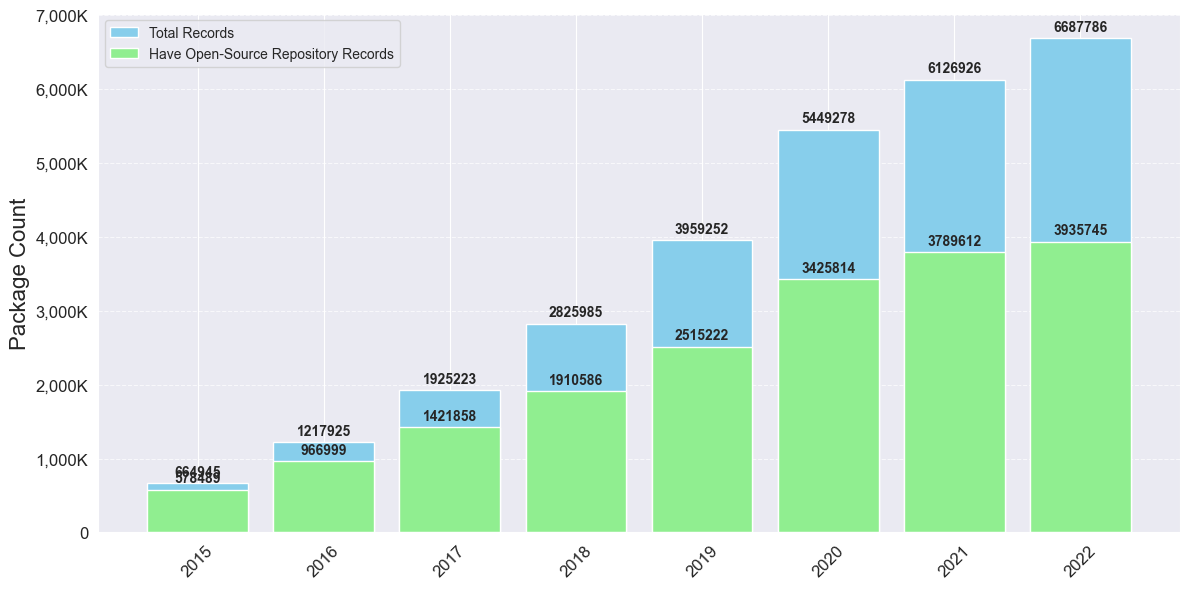

In [1]:
from clickhouse_driver import Client
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Establish a connection with the ClickHouse server
ch_client = Client(
    host='',
    port=,
    user='',
    password='',
    database=''
)

# SQL queries to get total package count and GitHub package count per year
total_packages_query = """
SELECT
    toYear(time) AS year,
    count() AS total_packages
FROM
    npm_records_v1
GROUP BY
    year
ORDER BY
    year;
"""

github_packages_query = """
SELECT
    toYear(time) AS year,
    count() AS github_packages
FROM
    npm_records_v1
WHERE
    repository_url LIKE '%github%' or repository_url LIKE '%gitlaqb%' or repository_url LIKE '%bitbucket%' or repository_url LIKE '%SourceForge%'
GROUP BY
    year
ORDER BY
    year;
"""

# Execute the SQL queries using the client and convert the results to pandas DataFrames
total_packages_df = pd.DataFrame(ch_client.execute(total_packages_query), columns=["year", "total_packages"])
github_packages_df = pd.DataFrame(ch_client.execute(github_packages_query), columns=["year", "github_packages"])

# Merge the DataFrames on the 'year' column
merged_df = pd.merge(total_packages_df, github_packages_df, on="year", how="left").fillna(0)

# Set up the basic information for the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create bar chart for total packages
total_bars = ax.bar(merged_df["year"], merged_df["total_packages"], color='skyblue', label='Total Records')

# Create bar chart for GitHub packages
github_bars = ax.bar(merged_df["year"], merged_df["github_packages"], color='lightgreen', label='Have Open-Source Repository Records')

# Add legend
ax.legend()

# Add grid lines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add Y-axis label with clear unit information
ax.set_ylabel("Package Count", fontsize=16)

# Define a custom formatting function for y-axis ticks
def format_ticks(value, _):
    if value >= 1000:
        value /= 1000
        return f'{int(value):,}K'
    else:
        return f'{int(value)}'

# Apply the custom formatting to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Add data labels with bold and larger fonts for total packages
for bar in total_bars:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add data labels with bold and larger fonts for GitHub packages
for bar in github_bars:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Adjust X-axis labels to avoid overlap
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add title with larger font
# plt.title("NPM Package Count Over Years", fontsize=14)
plt.savefig('Count Record of npm Packages Over Years.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()


diff = 32655


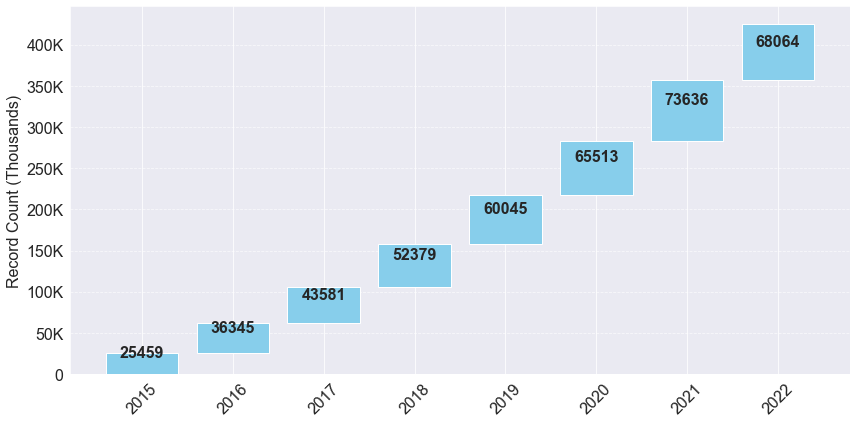

In [6]:
from clickhouse_driver import Client
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Establish a connection with the ClickHouse server
ch_client = Client(
    host='',
    port=,
    user='',
    password='',
    database=''
)

sql_query = """
SELECT
    toYear(time) AS year,
    count(distinct name) AS record_count
FROM
    npm_analysis_result_v1
GROUP BY
    year
ORDER BY
    year;
"""

# Execute the SQL query using the client and convert the result to a pandas DataFrame
df = pd.DataFrame(ch_client.execute(sql_query), columns=["year", "record_count"])

# Convert the year column to string for plotting
df["year"] = df["year"].astype(str)

# Calculate change and cumulative values
df["change"] = df["record_count"]
df["cumulative"] = df["record_count"].cumsum()

# Set up the basic information for the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Optimize color selection
colors = ["skyblue" for _ in df["change"]]

# Create bar chart
bars = ax.bar(df["year"], df["change"], bottom=df["cumulative"] - df["change"], color=colors)

# Add grid lines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add Y-axis label with clear unit information
ax.set_ylabel("Record Count (Thousands)", fontsize=16)  # Provide unit information

# Define a custom formatting function for y-axis ticks
def format_ticks(value, _):
    if value >= 1000:
        value /= 1000
        return f'{int(value):,}K'  # Format in thousands
    else:
        return f'{int(value)}'

# Apply the custom formatting to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Add data labels with bold and larger fonts
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height/2),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=16, fontweight='bold')

# Adjust X-axis labels to avoid overlap
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)

# Add title with larger font
# plt.title("Count Record of NPM Package Over Years", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


0-1: 155557
1-5: 935449
6-10: 343328
11-20: 191480
21-50: 143578
51-100: 69658
101-500: 112731
501-1000: 34756
1001-5000: 58136
5001-10000: 17676
10000+: 61397


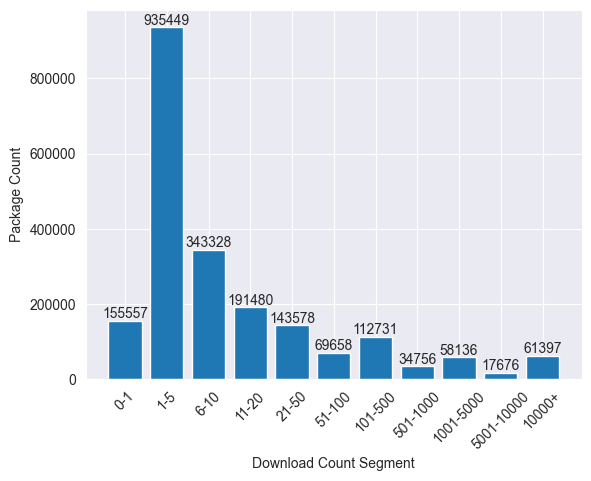

In [1]:
from clickhouse_driver import Client
import matplotlib.pyplot as plt

# 连接到ClickHouse数据库
ch_client = Client(
    host='',
    port=,
    user='',
    password='',
    database=''
)

# 执行查询获取数据
query = """
    SELECT
        COUNT(DISTINCT package) AS package_count,
        CASE
            WHEN download_count BETWEEN 0 AND 1 THEN '0-1'
            WHEN download_count BETWEEN 1 AND 5 THEN '1-5'
            WHEN download_count BETWEEN 6 AND 10 THEN '6-10'
            WHEN download_count BETWEEN 11 AND 20 THEN '11-20'
            WHEN download_count BETWEEN 21 AND 50 THEN '21-50'
            WHEN download_count BETWEEN 51 AND 100 THEN '51-100'
            WHEN download_count BETWEEN 101 AND 500 THEN '101-500'
            WHEN download_count BETWEEN 501 AND 1000 THEN '501-1000'
            WHEN download_count BETWEEN 1001 AND 5000 THEN '1001-5000'
            WHEN download_count BETWEEN 5001 AND 10000 THEN '5001-10000'
            ELSE '10000+'
        END AS download_count_segment
    FROM npm_package_v1_distinct
    GROUP BY download_count_segment
    ORDER BY
        CASE
            WHEN download_count_segment = '0-1' THEN 1
            WHEN download_count_segment = '1-5' THEN 2
            WHEN download_count_segment = '6-10' THEN 3
            WHEN download_count_segment = '11-20' THEN 4
            WHEN download_count_segment = '21-50' THEN 5
            WHEN download_count_segment = '51-100' THEN 6
            WHEN download_count_segment = '101-500' THEN 7
            WHEN download_count_segment = '501-1000' THEN 8
            WHEN download_count_segment = '1001-5000' THEN 9
            WHEN download_count_segment = '5001-10000' THEN 10
            ELSE 11
        END
"""

diff = 32655
result = ch_client.execute(query)

# 解析查询结果
segments = [row[1] for row in result]
counts = [row[0] for row in result]

# 在0-1段中添加diff
index_of_0_1 = segments.index('0-1')
# counts[index_of_0_1] += diff

# 输出每个下载计数段的值
for segment, count in zip(segments, counts):
    print(f"{segment}: {count}")

# 可视化
plt.bar(segments, counts)
plt.xlabel('Download Count Segment')
plt.ylabel('Package Count')
# 在每个条形上方添加数值标签
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
# plt.title('Package Count by Download Count Segment')
plt.xticks(rotation=45)
# 保存图形为矢量图格式（SVG）
plt.savefig('package_count.eps', format='eps', bbox_inches='tight')
plt.savefig('package_count.pdf', format='pdf', bbox_inches='tight')

# 显示图形
plt.show()


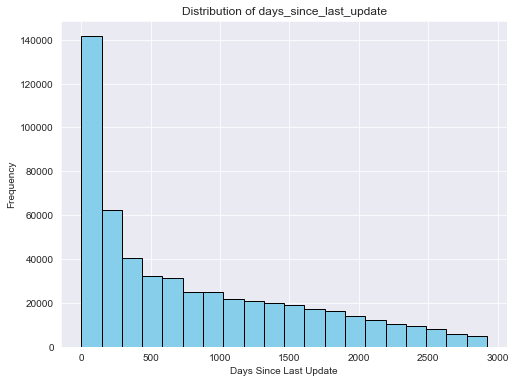

In [5]:
from clickhouse_driver import Client
import pandas as pd
import matplotlib.pyplot as plt

# Establish a connection with the ClickHouse server
ch_client = Client(
    host='',
    port=,
    user='',
    password='',
    database=''
)
# 执行SQL查询获取数据
query = "SELECT days_since_last_update FROM OutdatedDependencies_v1"
result = ch_client.execute(query)

# 将结果转换为Pandas DataFrame
df = pd.DataFrame(result, columns=['days_since_last_update'])

# 绘制统计图
plt.figure(figsize=(8, 6))
plt.hist(df['days_since_last_update'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of days_since_last_update')
plt.xlabel('Days Since Last Update')
plt.ylabel('Frequency')
plt.show()

# 计算统计数据
stats = df['days_since_last_update'].describe()
print(stats)

# 关闭ClickHouse连接
ch_client.disconnect()

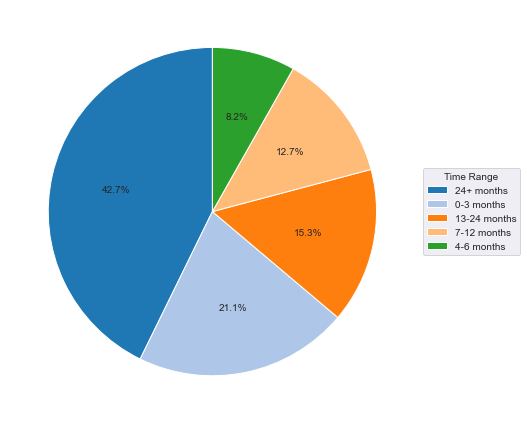

    count    time_range
1  229895    24+ months
4  113422    0-3 months
0   82245  13-24 months
3   68146   7-12 months
2   44059    4-6 months


In [7]:
from clickhouse_driver import Client
import pandas as pd
import matplotlib.pyplot as plt

# Establish a connection with the ClickHouse server
ch_client = Client(
    host='',
    port=,
    user='',
    password='',
    database=''
)
# SQL query
sql_query = """
SELECT COUNT(*) AS count, time_range
FROM OutdatedDependencies_v1
GROUP BY time_range;
"""

# Execute the SQL query using the client and convert the result to a pandas DataFrame
df = pd.DataFrame(ch_client.execute(sql_query), columns=["count", "time_range"])

# Sort dataframe for better color consistency
df.sort_values('count', ascending=False, inplace=True)

# Plotting pie chart
fig, ax = plt.subplots(figsize=(8, 6), )

# Define colors
colors = plt.get_cmap('tab20')(range(len(df)))

# Create pie chart
wedges, texts, autotexts = ax.pie(
    df["count"],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)

# Add legend outside the plot
plt.legend(
    wedges, df["time_range"],
    title="Time Range",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

# Set a more academic title
# plt.title("Figure 1: Distribution of Outdated Dependencies by Time Range", pad=20)

# Use tight layout to fit into an academic paper format
plt.tight_layout()

# Save the figure in a high-resolution format suitable for publication
plt.savefig("outdated_dependencies_distribution.png", format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
print(df)

    count    time_range
4  113422    0-3 months
0   82245  13-24 months
1  229895    24+ months
2   44059    4-6 months
3   68146   7-12 months
-------
    count    time_range
4   73851    0-3 months
0   47556  13-24 months
1  160050    24+ months
2   29478    4-6 months
3   43920   7-12 months


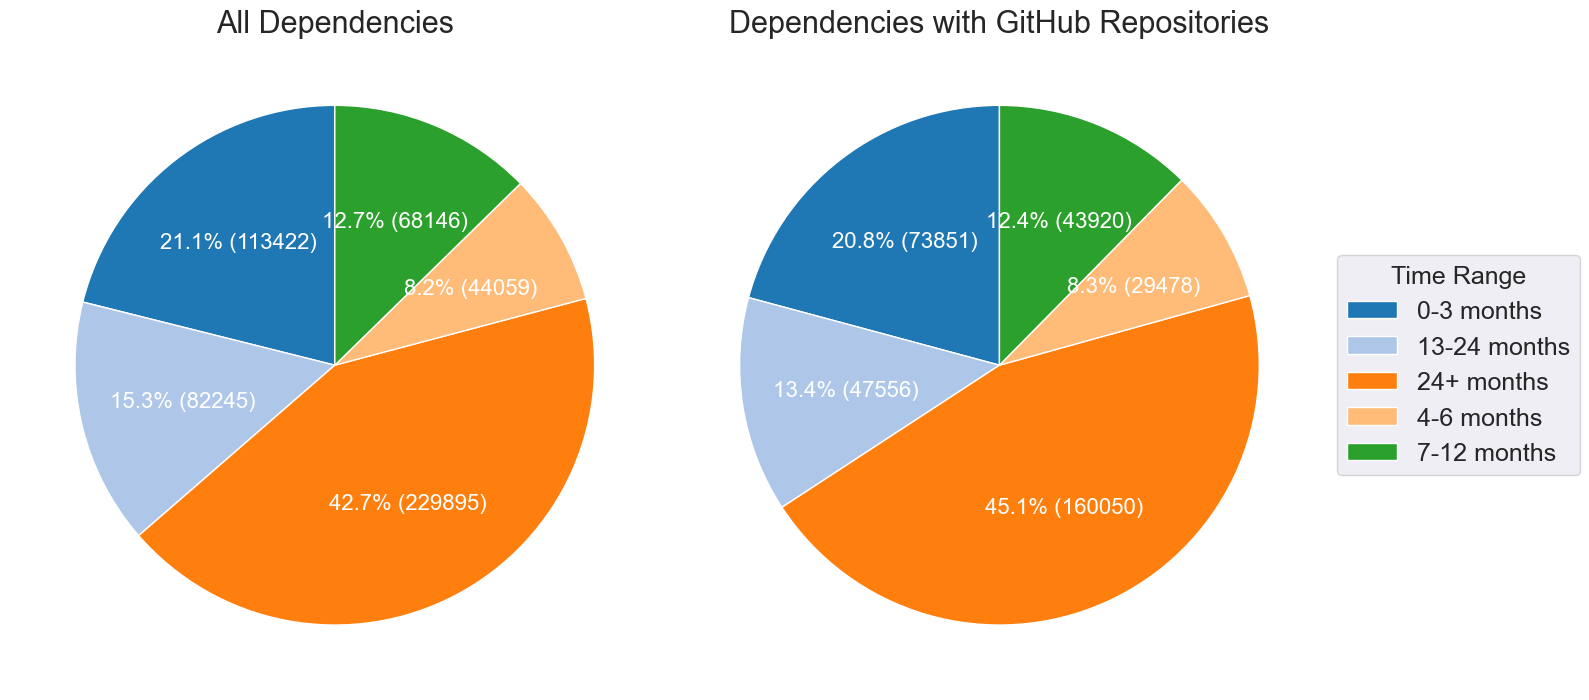

In [12]:
from clickhouse_driver import Client
import pandas as pd
import matplotlib.pyplot as plt

# Establish a connection with the ClickHouse server
ch_client = Client(
    host='',
    port=3306,
    user='xlab',
    password='Xlab2021!',
    database='supply_chain'
)

# SQL query for all repositories
sql_query_all = """
SELECT COUNT(*) AS count, time_range
FROM OutdatedDependencies_v1
GROUP BY time_range;
"""

# SQL query for GitHub repositories
sql_query_github = """
SELECT COUNT(*) AS count, time_range
FROM OutdatedDependencies_v1
WHERE repository_url LIKE '%github%'
GROUP BY time_range;
"""

# Execute the SQL queries
df_all = pd.DataFrame(ch_client.execute(sql_query_all), columns=["count", "time_range"])
df_github = pd.DataFrame(ch_client.execute(sql_query_github), columns=["count", "time_range"])

# Sort dataframes by time_range for consistent coloring across charts
df_all.sort_values('time_range', inplace=True)
df_github.sort_values('time_range', inplace=True)
print(df_all)
print("-------")
print(df_github)
# Plotting pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Define colors based on unique time ranges in df_all (assuming both dataframes have the same time_ranges)
unique_time_ranges = df_all['time_range'].unique()
colors = plt.get_cmap('tab20')(range(len(unique_time_ranges)))
color_map = dict(zip(unique_time_ranges, colors))

# Define font sizes
font_size = 20  # You can adjust this size based on your preference or requirements
legend_font_size = 18  # Smaller font for the legend

# Function to format the autopct with actual count
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}% ({val:d})'
    return my_format

# Create pie chart for all repositories
wedges1, texts1, autotexts1 = ax1.pie(
    df_all["count"],
    labels=None,
    autopct=autopct_format(df_all["count"]),
    startangle=90,
    colors=[color_map[time] for time in df_all["time_range"]],
    textprops={'fontsize': font_size}
)
ax1.set_title('All Dependencies', fontsize=font_size + 2)

# # 调整百分比标签的字体大小
# for autotext in autotexts1:
#     autotext.set_color('white')
#     autotext.set_fontsize(22)

# Create pie chart for GitHub repositories
wedges2, texts2, autotexts2 = ax2.pie(
    df_github["count"],
    labels=None,
    autopct=autopct_format(df_github["count"]),
    startangle=90,
    colors=[color_map[time] for time in df_github["time_range"]],
    textprops={'fontsize': font_size}
)
ax2.set_title('Dependencies with GitHub Repositories', fontsize=font_size + 2)

# Add actual count to the outer edge of the pie charts
for autotext in autotexts1 + autotexts2:
    autotext.set_color('white')  # Set color to black
    autotext.set_fontsize(16)  # Adjust font size for outer text

# Add legend outside the plot
legend = plt.legend(
    wedges1,
    [time for time in unique_time_ranges],
    title="Time Range",
    title_fontsize=legend_font_size,
    fontsize=legend_font_size,
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

# Use tight layout to fit into an academic paper format
plt.tight_layout()

# Save the figure in a high-resolution format suitable for publication
plt.savefig("outdated_dependencies_comparison.pdf", format='pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


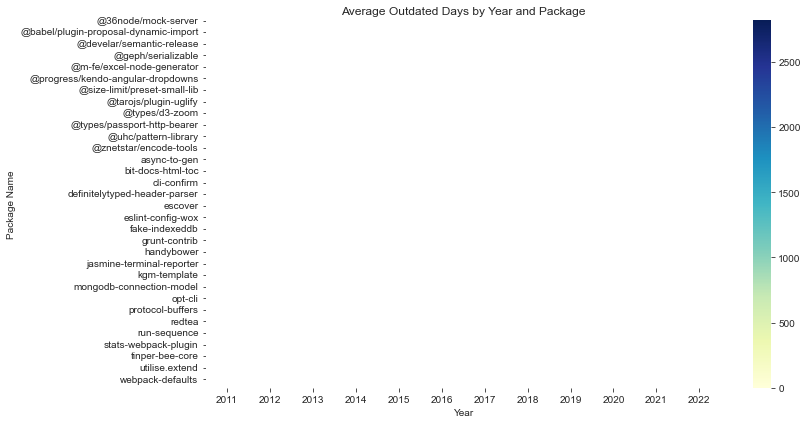

In [50]:
from clickhouse_driver import Client
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Establish a connection with the ClickHouse server
ch_client = Client(
    host='',
    port=,
    user='',
    password='',
    database='supply_chain'
)

# SQL query
sql_query = """
SELECT
    toStartOfMonth(time) as month,
    name,
    AVG(days_difference) as avg_outdated_days
FROM npm_analysis_result_v2
GROUP BY month, name;
"""

# Fetch data
data = ch_client.execute(sql_query)
df = pd.DataFrame(data, columns=['month', 'name', 'avg_outdated_days'])

# Convert the 'month' column to datetime and extract the year
df['year'] = pd.to_datetime(df['month']).dt.year

# Group by year and name, then compute average outdated days
df_grouped = df.groupby(['year', 'name']).avg_outdated_days.mean().reset_index()

# Create the heatmap
plt.figure(figsize=(12, 6))
heatmap_data = df_grouped.pivot_table(values="avg_outdated_days", index="name", columns="year").fillna(0)
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=.5, vmin=0, vmax=heatmap_data.values.max())

plt.title("Average Outdated Days by Year and Package")
plt.ylabel("Package Name")
plt.xlabel("Year")
plt.tight_layout()
plt.show()


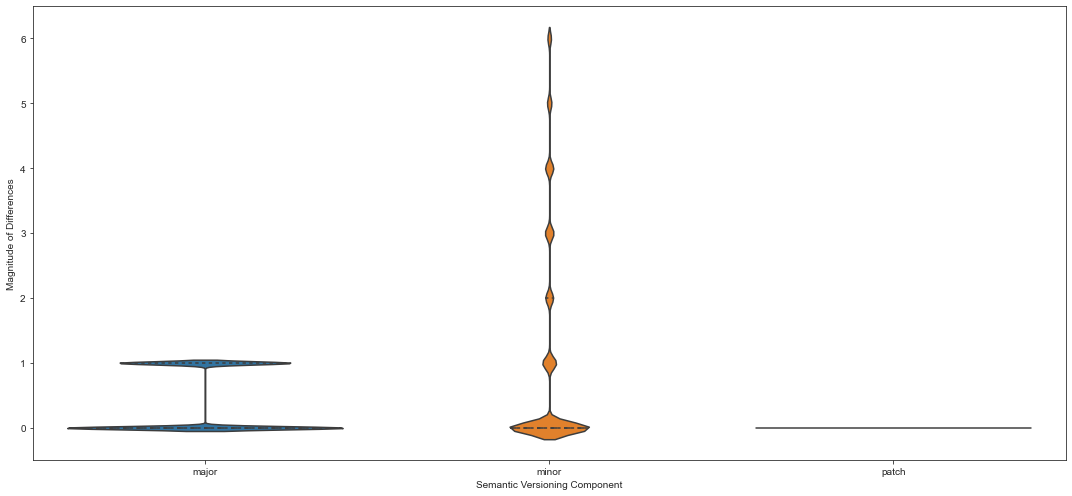

In [53]:
from clickhouse_driver import Client
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Establish a connection with the ClickHouse server
ch_client = Client(
    host='',
    port=,
    user='',
    password='',
    database=''
)

sql_query = """
SELECT
    major_difference AS major,
    minor_difference AS minor,
    patch_difference AS patch,
    SUM(occurrences) AS total_occurrences
FROM version_difference_filtered_v2
WHERE
    (major_difference < 0) OR
    (minor_difference < 0) OR
    (patch_difference < 0)
GROUP BY major, minor, patch
ORDER BY total_occurrences DESC;
"""

# Execute the SQL query using the client and convert the result to a pandas DataFrame
df = pd.DataFrame(ch_client.execute(sql_query), columns=["major", "minor", "patch", "total_occurrences"])

# Convert all negative values to positive
for col in ["major", "minor", "patch"]:
    df[col] = df[col].abs()

# Melt the DataFrame for easier plotting
df_melted = df.melt(id_vars=["total_occurrences"], value_vars=["major", "minor", "patch"],
                    var_name="Version Component", value_name="Difference Magnitude")

# Repeat each row based on the 'total_occurrences' column
df_melted = df_melted.loc[df_melted.index.repeat(df_melted['total_occurrences'])].reset_index(drop=True)

#  Remove outliers based on IQR for each "Version Component"
multiplier = 0.25  # 调整为1.25
components = ["major", "minor", "patch"]
for component in components:
    component_data = df_melted[df_melted["Version Component"] == component]["Difference Magnitude"]
    Q1 = component_data.quantile(0.25)
    Q3 = component_data.quantile(0.75)
    IQR = Q3 - Q1
    filter_mask = ((component_data >= (Q1 - multiplier * IQR)) & (component_data <= (Q3 + multiplier * IQR)))
    df_melted = df_melted[(df_melted["Version Component"] != component) | filter_mask]


# Plotting the data using seaborn without outliers
plt.figure(figsize=(15, 7))
sns.violinplot(x="Version Component", y="Difference Magnitude", data=df_melted, inner="quartile")
plt.ylabel("Magnitude of Differences")
plt.xlabel("Semantic Versioning Component")

plt.tight_layout()
plt.show()


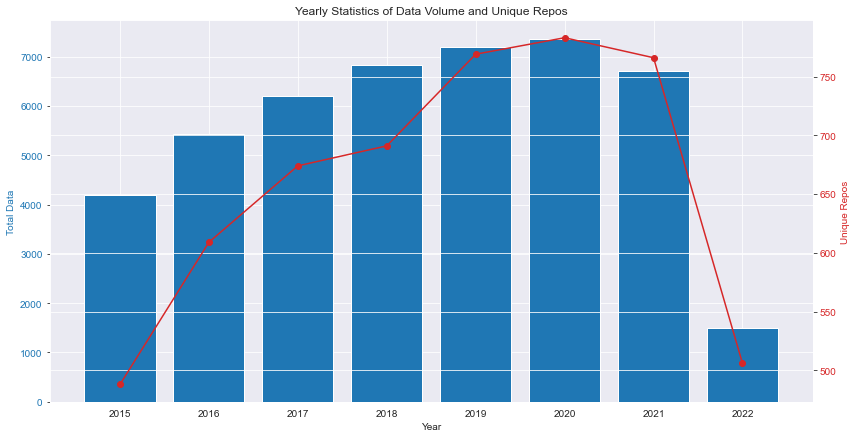

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
df = pd.read_csv('data/merged.csv')

# 提取年份
df['Year'] = pd.to_datetime(df['Date']).dt.year

# 按年份统计数据量和repo_name的唯一数量
grouped_data = df.groupby('Year').agg(
    total_data=pd.NamedAgg(column='Date', aggfunc='count'),
    unique_repos=pd.NamedAgg(column='repo_name', aggfunc='nunique')
).reset_index()

# 绘制数据总量和repo_name的总量的条形图
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Data', color=color)
ax1.bar(grouped_data['Year'], grouped_data['total_data'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Unique Repos', color=color)
ax2.plot(grouped_data['Year'], grouped_data['unique_repos'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Yearly Statistics of Data Volume and Unique Repos')
plt.show()


In [5]:
import pandas as pd

# 读取数据
df = pd.read_csv('data/merged.csv')

# 提取年份
df['Year'] = pd.to_datetime(df['Date']).dt.year

# 按年份统计数据量和repo_name的唯一数量
grouped_data = df.groupby('Year').agg(
    total_data=pd.NamedAgg(column='Date', aggfunc='count'),
    unique_repos=pd.NamedAgg(column='repo_name', aggfunc='nunique')
).reset_index()

print(grouped_data)


   Year  total_data  unique_repos
0  2015        4192           488
1  2016        5432           609
2  2017        6200           674
3  2018        6821           691
4  2019        7204           769
5  2020        7366           783
6  2021        6707           766
7  2022        1499           506


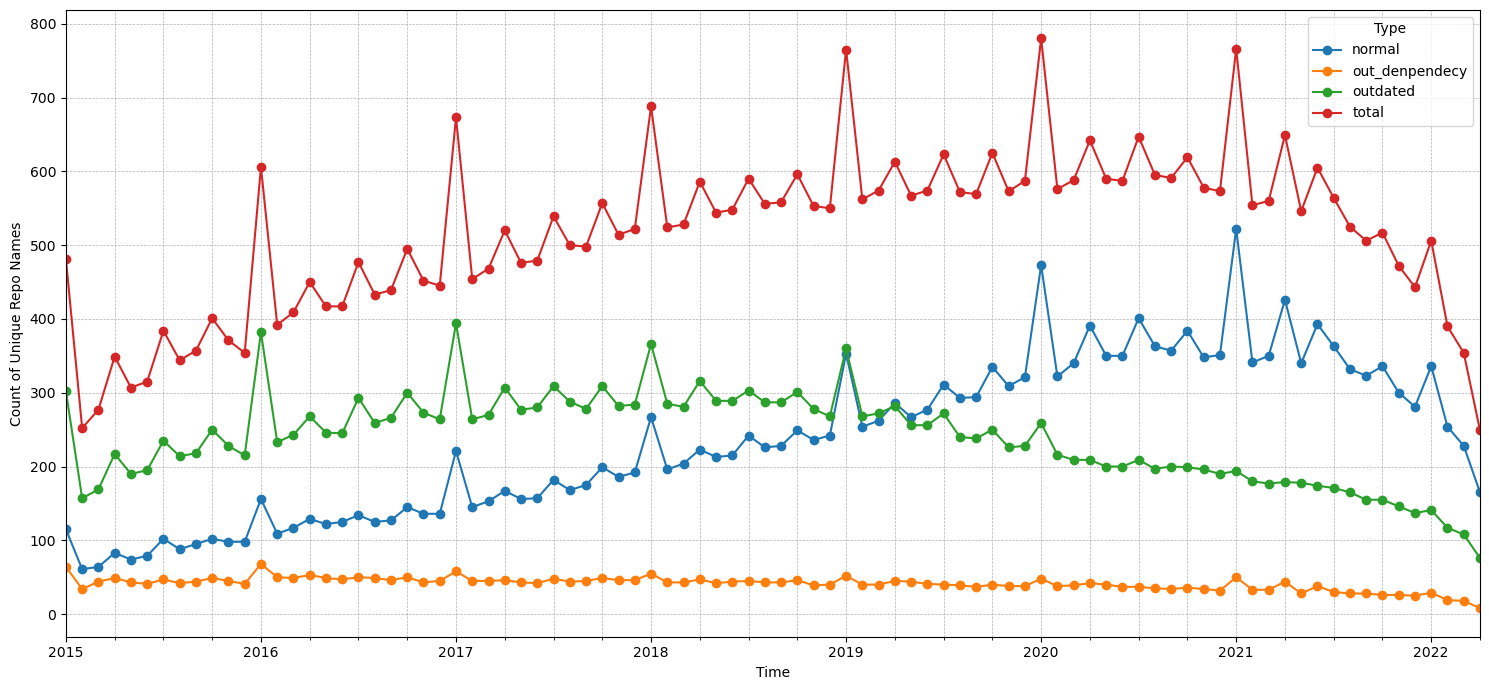

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Read CSV file
df = pd.read_csv('data/merged_with_type.csv')

# Convert the Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract year and month
df['YearMonth'] = df['Date'].dt.to_period('M')

# Group by YearMonth and type, and count unique repo_names
repo_name_counts_by_type = df.groupby(['YearMonth', 'type'])['repo_name'].nunique().unstack()

# Add a total count for all repo_name types
repo_name_counts_by_type['total'] = repo_name_counts_by_type.sum(axis=1)

# Create a new figure and set the size
plt.figure(figsize=(15, 7))

# Plot the count of unique repo_names for each type
for column in repo_name_counts_by_type.columns:
    repo_name_counts_by_type[column].plot(label=column, marker='o', linestyle='-')

# Set the title, labels, and legend
# plt.title('Unique Repo Names by Year, Month, and Type')  # Un-comment this line if you want a title
plt.xlabel('Time')
plt.ylabel('Count of Unique Repo Names')
plt.legend(title='Type')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Ensure the background is white
plt.style.use('default')
plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

# Display the plot
plt.tight_layout()
plt.show()


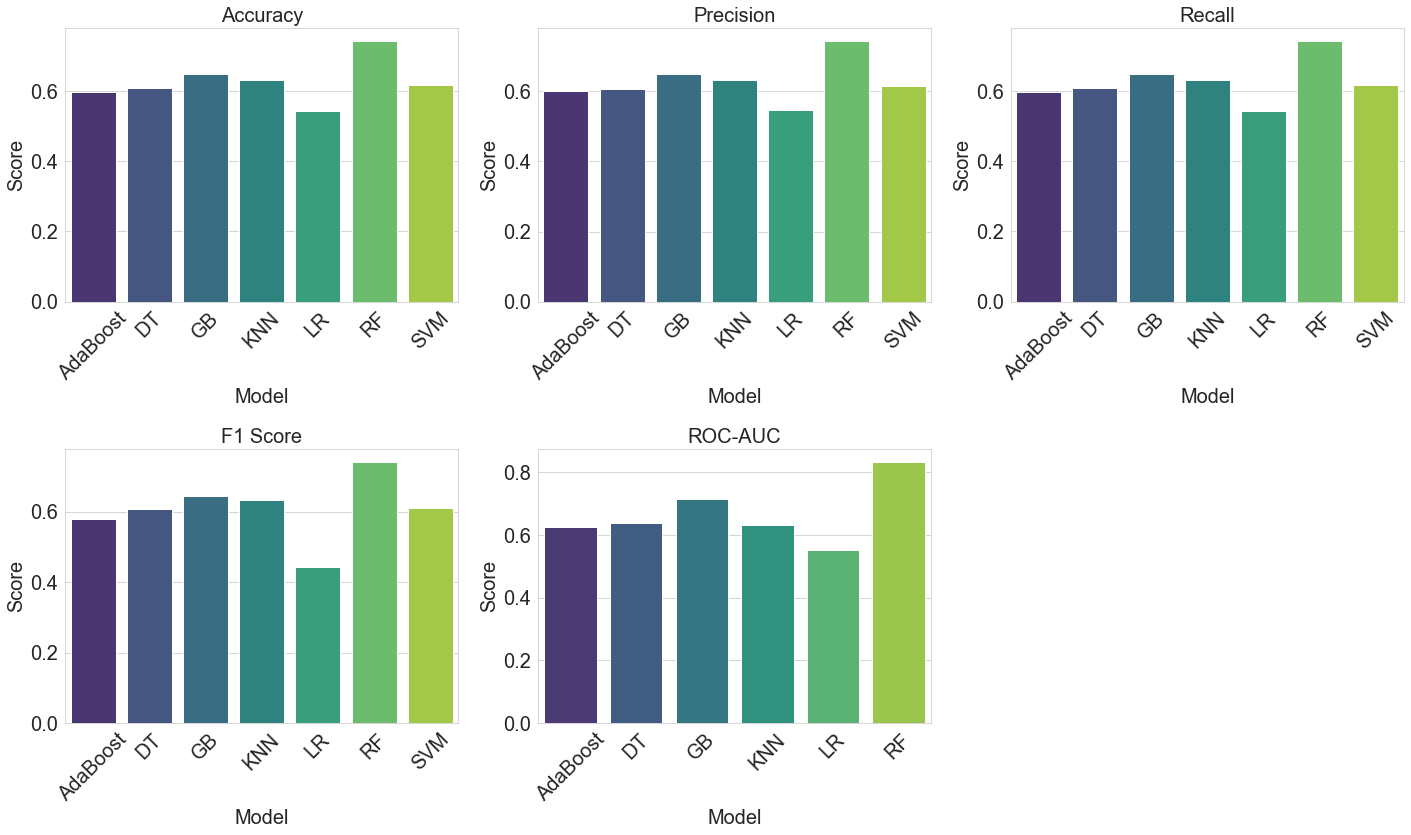

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Setting font sizes
plt.rcParams.update({'font.size': 20})  # Sets the default font size for all text
title_fontsize = 20  # Font size for titles
label_fontsize = 20  # Font size for labels

# Loading metrics
models = [
    "AdaBoost", "DT", "GB",
    "KNN", "LR", "RF",
    "SVM"
]
metrics_data = {}

for model in models:
    df = pd.read_csv(f"./result/{model}_metrics.csv")
    # Replace 'Not Available' with NaN and drop such rows
    df = df.replace('Not Available', float('nan')).dropna(subset=['Value'])
    df["Value"] = df["Value"].astype(float)  # Ensure the values are float
    metrics_data[model] = df

# Setting Seaborn style
sns.set_style("whitegrid")

# Plotting metrics in one plot
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"]

data = []
for model in models:
    for metric in metrics:
        if metric in metrics_data[model]['Metric'].values:
            value = metrics_data[model].set_index("Metric").loc[metric, "Value"]
            data.append([model, metric, value])

df_plot = pd.DataFrame(data, columns=["Model", "Metric", "Value"])

for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    sns.barplot(data=df_plot[df_plot["Metric"] == metric], x="Model", y="Value", ax=ax, palette="viridis")
    ax.set_title(metric, fontsize=title_fontsize)
    ax.set_ylabel("Score", fontsize=label_fontsize)
    ax.set_xlabel("Model", fontsize=label_fontsize)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

# Remove the unused subplot (bottom right corner)
axes[1, 2].axis("off")

plt.tight_layout()

plt.savefig("./chart/metrics_visualization.pdf", format='pdf')

plt.show()




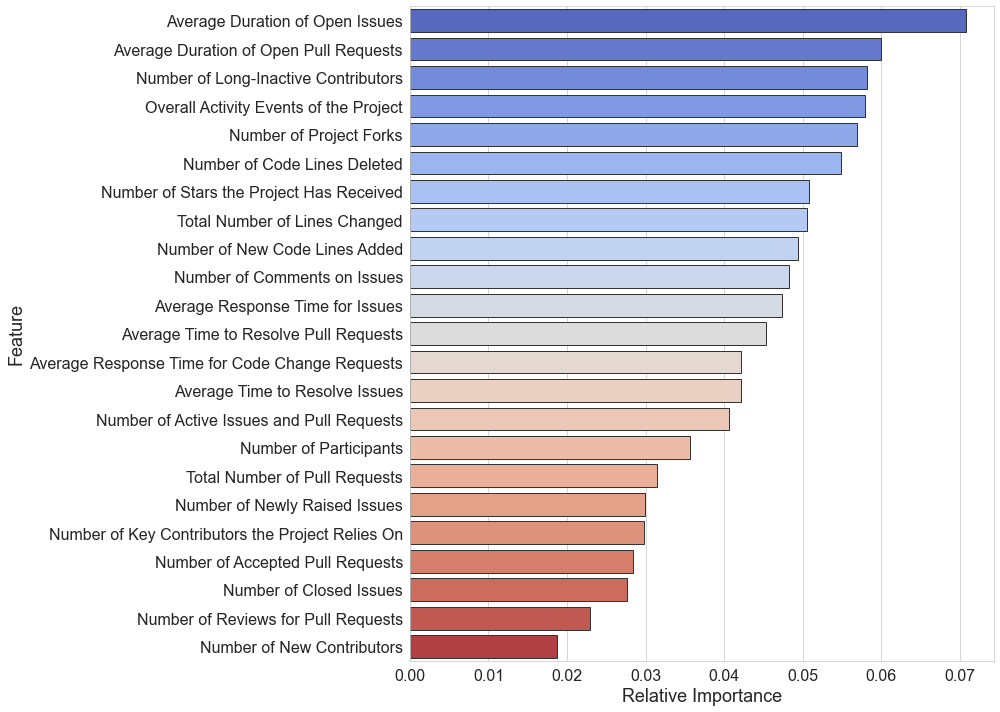

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Updated map for original feature to descriptive names
feature_mapping = {
    "new_contributors": "Number of New Contributors",
    "change_request_response_time_avg": "Average Response Time for Code Change Requests",
    "issue_age_avg": "Average Duration of Open Issues",
    "code_change_lines_sum": "Total Number of Lines Changed",
    "issues_new": "Number of Newly Raised Issues",
    "issues_and_change_request_active": "Number of Active Issues and Pull Requests",
    "code_change_lines_add": "Number of New Code Lines Added",
    "attention": "Number of Project Forks",
    "issue_comments": "Number of Comments on Issues",
    "change_requests_accepted": "Number of Accepted Pull Requests",
    "change_request_age_avg": "Average Duration of Open Pull Requests",
    "participants": "Number of Participants",
    "bus_factor": "Number of Key Contributors the Project Relies On",
    "code_change_lines_remove": "Number of Code Lines Deleted",
    "inactive_contributors": "Number of Long-Inactive Contributors",
    "change_requests_reviews": "Number of Reviews for Pull Requests",
    "activity": "Overall Activity Events of the Project",
    "change_request_resolution_duration_avg": "Average Time to Resolve Pull Requests",
    "issues_closed": "Number of Closed Issues",
    "change_requests": "Total Number of Pull Requests",
    "issue_response_time_avg": "Average Response Time for Issues",
    "issue_resolution_duration_avg": "Average Time to Resolve Issues",
    "stars": "Number of Stars the Project Has Received"
}

# Read the data
df = pd.read_csv("./result/Random Forest Classifier_feature_importances.csv")

# Map the features to their descriptive names
df['Feature'] = df['Feature'].map(feature_mapping)

df.to_csv('feature_importance.csv', index=False)

# Sort by Importance for better visualization
df = df.sort_values(by="Importance", ascending=False)

# Set style for the plot
sns.set_style("whitegrid")

# Set a larger figure size for better readability
plt.figure(figsize=(14, 10))

# Create a color palette
palette = sns.color_palette("coolwarm", len(df))

# Plot - flipped x and y for a horizontal bar plot
sns.barplot(y="Feature", x="Importance", data=df, palette=palette, edgecolor=".2")

# Title and labels
# plt.title("Feature Importances as Determined by Random Forest Classifier", fontsize=20, pad=20)
plt.xlabel("Relative Importance", fontsize=18)
plt.ylabel("Feature", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


In [5]:
import pandas as pd

# Model list
models = [
    "AdaBoost Classifier", "Decision Tree Classifier", "Gradient Boosting Classifier",
    "K-Nearest Neighbors", "Logistic Regression", "Random Forest Classifier",
    "Support Vector Machine"
]

# Placeholder for the data
all_metrics = []

# Loop through each model to read the metrics file and append to all_metrics
for model in models:
    df = pd.read_csv(f"./result/{model}_metrics.csv")
    df['Model'] = model
    all_metrics.append(df)

# Concatenate all metrics data
consolidated_metrics = pd.concat(all_metrics, ignore_index=True)

# Save the consolidated data to a new file
consolidated_metrics.to_csv("./result/Consolidated_Metrics.csv", index=False)


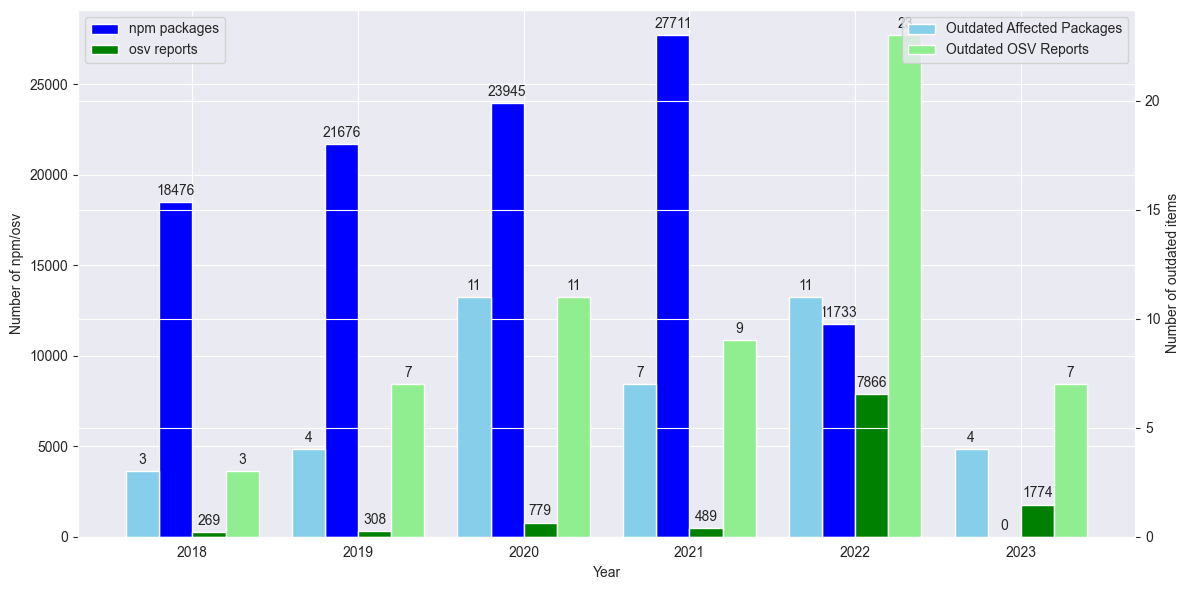

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 数据准备
data = {
    'Year': ['2018', '2019', '2020', '2021', '2022', '2023'],
    'npm_packages': [18476, 21676, 23945, 27711, 11733, 0],
    'osv_reports': [269, 308, 779, 489, 7866, 1774],
    'outdated_affected_packages': [3, 4, 11, 7, 11, 4],
    'outdated_osv_reports': [3, 7, 11, 9, 23, 7]
}

df = pd.DataFrame(data)
x = np.arange(len(df['Year']))  # the label locations

# 条形图宽度
width = 0.2

fig, ax1 = plt.subplots(figsize=(12, 6))

# 主要柱状图
rects1 = ax1.bar(x - width/2, df['npm_packages'], width, label='npm packages', color='blue')
rects2 = ax1.bar(x + width/2, df['osv_reports'], width, label='osv reports', color='green')

# 第二个轴（共享x轴）
ax2 = ax1.twinx()

# 次要柱状图
rects3 = ax2.bar(x - 3*width/2, df['outdated_affected_packages'], width, label='Outdated Affected Packages', color='skyblue')
rects4 = ax2.bar(x + 3*width/2, df['outdated_osv_reports'], width, label='Outdated OSV Reports', color='lightgreen')

# 添加文本标签
def autolabel(rects, ax, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1, ax1)
autolabel(rects2, ax1)
autolabel(rects3, ax2, 'left')
autolabel(rects4, ax2, 'right')

# 设置图表标题和坐标轴标签
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of npm/osv')
ax2.set_ylabel('Number of outdated items')

# 设置x轴刻度标签
ax1.set_xticks(x)
ax1.set_xticklabels(df['Year'])

# 图例
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()

plt.show()


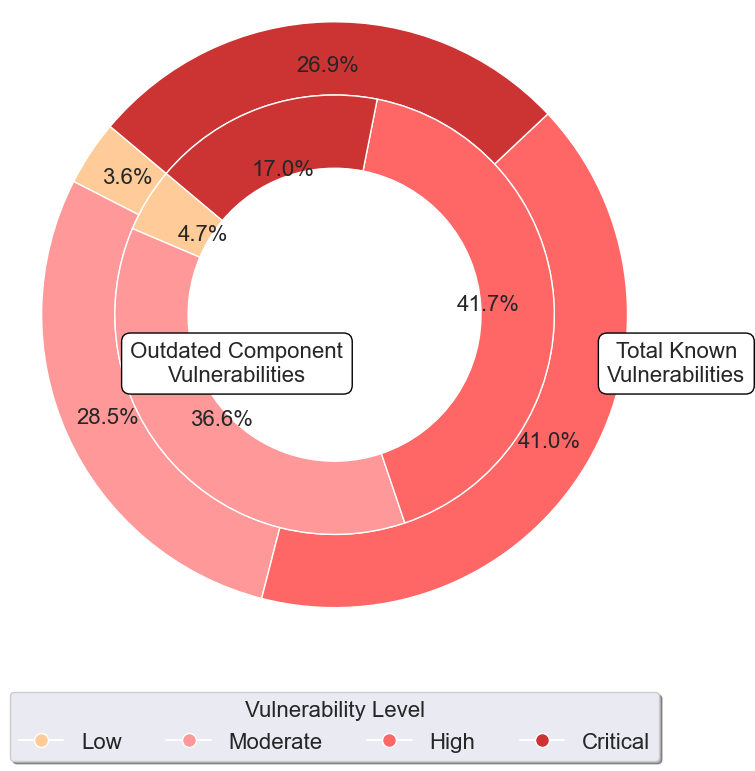

In [5]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})  # Sets the default font size for all text

categories = ['Low', 'Moderate', 'High', 'Critical']
colors = ['#ffcc99', '#ff9999', '#ff6666', '#cc3333']  # Colors from light to dark

package_vulns_pct = [4.70, 36.59, 41.71, 17.00]
total_vulns_pct = [3.60, 28.51, 41.03, 26.87]

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(aspect="equal"))

wedges1, texts1, autotexts1 = ax.pie(total_vulns_pct, radius=1.2, colors=colors, startangle=140,
                                     wedgeprops=dict(width=0.3, edgecolor='w'),
                                     autopct='%1.1f%%', pctdistance=0.85)

wedges2, texts2, autotexts2 = ax.pie(package_vulns_pct, radius=0.9, colors=colors, startangle=140,
                                     wedgeprops=dict(width=0.3, edgecolor='w'),
                                     autopct='%1.1f%%', pctdistance=0.7)

centre_circle = plt.Circle((0,0),0.6, color='white', fc='white', linewidth=0)
fig.gca().add_artist(centre_circle)

# Adjust annotations
def add_pie_annotation(text, xpos, ypos):
    ax.text(xpos, ypos, text, ha='center', va='center', fontsize=16,
            bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=1))

add_pie_annotation('Outdated Component\nVulnerabilities', -0.4, -0.2)
add_pie_annotation('Total Known\nVulnerabilities', 1.4, -0.2)

# Configure and place the legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=cat,
                              markerfacecolor=col, markersize=10) for cat, col in zip(categories, colors)]
ax.legend(handles=legend_elements, title="Vulnerability Level", loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4)

fig.tight_layout()
plt.savefig("./chart/outdated_component_distribution.pdf", format='pdf', bbox_inches='tight')
plt.show()
